In [1]:
import h5py

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


In [3]:
background_dataset_name = 'background_dataset.h5'

In [4]:
with h5py.File(background_dataset_name) as f:
    X_test = f['X_test'][()]
    X_train = f['X_train'][()]
    X_val = f['X_val'][()]

In [5]:
X_test = torch.from_numpy(X_test.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)
X_train = torch.from_numpy(X_train.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)
X_val = torch.from_numpy(X_val.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)

In [6]:
X_test[0]

tensor([[65.4762, 37.9355,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 21.6817,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.2620,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  2.9084,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [-2.7295,  0.6561,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.7582,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]])

In [7]:
X_train[0][1:5,:]

tensor([[ 0.0000, -1.7329, -0.3801,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -1.7329,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 1.9248, -2.5162,  0.6048,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -2.5162,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]])

In [8]:
# torch.random.seed()

class HEPDataSet(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset.clone()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        return self.dataset[idx]

In [9]:
train_set = HEPDataSet(X_train)
val_set = HEPDataSet(X_val)
test_set = HEPDataSet(X_test)

In [10]:
batch_size = 4000
train_data_loader = DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True,
)
val_data_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=True,
)
test_data_loader = DataLoader(
    test_set, batch_size=1,
    shuffle=True,
)

In [11]:
len(train_data_loader)

2153

In [12]:
for idx, val in enumerate(train_data_loader):
    break

In [13]:
for idx, val1 in enumerate(train_data_loader):
    if idx==2: break

In [14]:
val.shape

torch.Size([4000, 3, 19])

In [15]:
# Implemented from https://github.com/violatingcp/codec/blob/main/losses.py
class VICRegLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)

        x_mu = x.mean(dim=0)
        x_std = x.std(dim=0) + 1e-2
        y_mu = y.mean(dim=0)
        y_std = y.std(dim=0) + 1e-2
        
        x = (x - x_mu)/x_std
        y = (y - y_mu)/y_std

        N = x.size(0)
        D = x.size(-1)

        std_loss = torch.mean(F.relu(1 - x_std, inplace=False)) / 2
        std_loss += torch.mean(F.relu(1 - y_std, inplace=False)) / 2

        cov_x = (x.transpose(1, 2).contiguous() @ x) / (N - 1)
        cov_y = (y.transpose(1, 2).contiguous() @ y) / (N - 1)

        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        return repr_loss + cov_loss + std_loss

    def off_diagonal(self, x):
        num_batch, n, m = x.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return x.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()

In [16]:
vicreg_loss = VICRegLoss()

In [17]:
from nflows.nn.nets import ResidualNet
from nflows import transforms, distributions, flows

In [39]:
class SimilarityEmbedding(nn.Module):
    """An embedding with resnets"""
    def __init__(self):
        super().__init__()
        self.resnet = ResidualNet(19, 1, 100)

    def forward(self, x):
        res_embedding = self.resnet(x)
        #b, h, w = res_embedding.shape
        #return res_embedding.reshape(b, 1, h*w)
        return res_embedding

In [40]:
similarity_embedding = SimilarityEmbedding()

optimizer = torch.optim.Adam(similarity_embedding.parameters(), lr=1e-5)

scheduler_1 = torch.optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [41]:
# similarity_embedding(m, e, mu, jet)

In [42]:
val.shape

torch.Size([1, 3, 19])

In [43]:
similarity_embedding(val).shape

torch.Size([1, 3, 1])

In [44]:
def train_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        if val.shape[0] != batch_size:
            continue

        first_val_repeated = val[0].repeat(batch_size, 1, 1)
        
        embedded_values_aug = similarity_embedding(first_val_repeated)
        embedded_values_orig = similarity_embedding(val)

        similar_embedding_loss = vicreg_loss(embedded_values_aug, embedded_values_orig)

        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        if idx % 500 == 0:
            last_sim_loss = running_sim_loss / 500
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        if val.shape[0] != batch_size:
            continue
        first_val_repeated = val[0].repeat(batch_size, 1, 1)
        
        embedded_values_aug = similarity_embedding(first_val_repeated)
        embedded_values_orig = similarity_embedding(val)

        similar_embedding_loss = vicreg_loss(embedded_values_aug, embedded_values_orig)

        running_sim_loss += similar_embedding_loss.item()
        if idx % 50 == 0:
            last_sim_loss = running_sim_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [46]:
writer = SummaryWriter("hep_sim_together_round_2", comment="Similarity with LR=1e-3", flush_secs=5)
epoch_number = 0

In [47]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 10

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 500 batches = 9.3904
 Avg. train loss/batch after 1000 batches = 6.5554
 Avg. train loss/batch after 1500 batches = 5.4307
 Avg. train loss/batch after 2000 batches = 4.3219
Train/Val Sim Loss after epoch: 4.3219/4.0205
EPOCH 2:
 Avg. train loss/batch after 500 batches = 3.7109
 Avg. train loss/batch after 1000 batches = 3.2320
 Avg. train loss/batch after 1500 batches = 2.5048
 Avg. train loss/batch after 2000 batches = 1.9421
Train/Val Sim Loss after epoch: 1.9421/4.0490
EPOCH 3:
 Avg. train loss/batch after 500 batches = 1.8178
 Avg. train loss/batch after 1000 batches = 1.4311
 Avg. train loss/batch after 1500 batches = 1.3433
 Avg. train loss/batch after 2000 batches = 1.2645
Train/Val Sim Loss after epoch: 1.2645/1.2391
EPOCH 4:
 Avg. train loss/batch after 500 batches = 1.2637
 Avg. train loss/batch after 1000 batches = 1.1927
 Avg. train loss/batch after 1500 batches = 1.2168
 Avg. train loss/batch after 2000 batches = 1.1326
Train/Val Sim 

/home/deep/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 500 batches = 1.0859
 Avg. train loss/batch after 1000 batches = 1.0356
 Avg. train loss/batch after 1500 batches = 1.0353
 Avg. train loss/batch after 2000 batches = 1.0493
Train/Val Sim Loss after epoch: 1.0493/1.0500
EPOCH 7:
 Avg. train loss/batch after 500 batches = 1.0105
 Avg. train loss/batch after 1000 batches = 1.0029
 Avg. train loss/batch after 1500 batches = 1.0006
 Avg. train loss/batch after 2000 batches = 1.0072
Train/Val Sim Loss after epoch: 1.0072/1.0857
EPOCH 8:
 Avg. train loss/batch after 500 batches = 0.9925
 Avg. train loss/batch after 1000 batches = 1.0014
 Avg. train loss/batch after 1500 batches = 0.9928
 Avg. train loss/batch after 2000 batches = 1.0005
Train/Val Sim Loss after epoch: 1.0005/0.9713
EPOCH 9:
 Avg. train loss/batch after 500 batches = 0.9905
 Avg. train loss/batch after 1000 batches = 1.0000
 Avg. train loss/batch after 1500 batches = 0.9882
 Avg. train loss/batch after 2000 batches = 0.9821
Train/Val Sim Loss afte

In [48]:
# PATH = "./similarity_model_together.pt"
# torch.save(similarity_embedding.state_dict(), PATH)
# similarity_embedding.load_state_dict(torch.load(PATH))

# Test set

In [49]:
sim_vals = []

for idx, val in enumerate(test_data_loader, 1):
    if idx % 1000 == 0: break
    with torch.no_grad():
        sim_val = similarity_embedding(val)
        sim_vals.append(sim_val)

In [50]:
sim_vals = torch.stack(sim_vals).reshape(999, 3)

In [51]:
sim_vals.shape

torch.Size([999, 3])

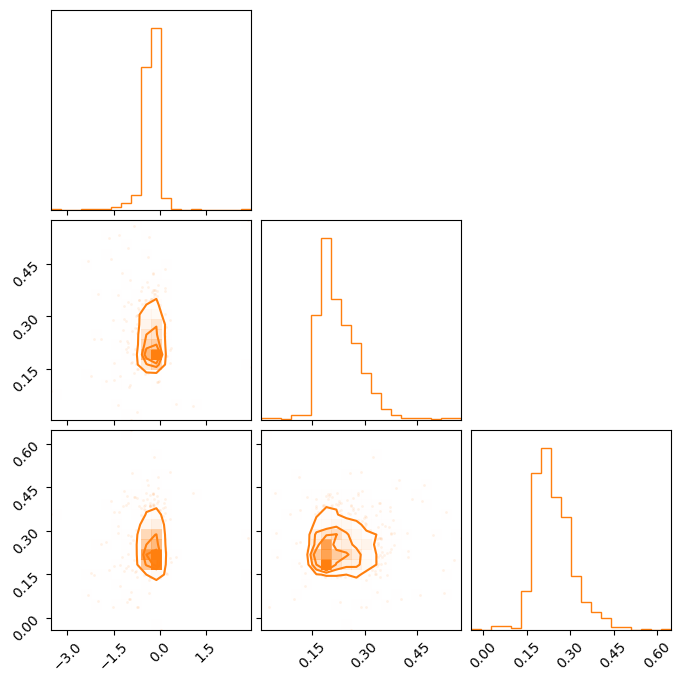

In [52]:
import corner

figure = corner.corner(
    sim_vals.numpy(), color="C1"
)

# figure = corner.corner(
#     sim_e_vals.numpy(), color="C2", fig=figure
# )
# figure = corner.corner(
#     similarity_outputs_2.reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], 2)),
#     quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
# )

In [53]:
# Freeze weights
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = False

In [141]:
num_layers = 5
base_dist = distributions.StandardNormal(shape=[3])

transform_layers = []
for _ in range(num_layers):
    transform_layers.append(transforms.permutations.ReversePermutation(features=3))
    transform_layers.append(
        transforms.autoregressive.MaskedAffineAutoregressiveTransform(
            features=3,
            hidden_features=4
        )
    )
transform_obj = transforms.CompositeTransform(transform_layers)

flow_obj = flows.Flow(transform_obj, base_dist)
optimizer = torch.optim.Adam(flow_obj.parameters(), lr=1e-3)

In [142]:
similarity_embedding(val).shape

torch.Size([3, 1])

In [150]:
num_iter = 10
for i in range(num_iter):
    for idx, val in enumerate(train_data_loader):
        if idx == 1000:
            break
        sim_val = similarity_embedding(val).reshape(4000, 3)
        optimizer.zero_grad()
        loss = -flow_obj.log_prob(inputs=sim_val).mean()
        loss.backward()
        optimizer.step()
    print(loss.item())

-1.1702156066894531
-1.6734691858291626
-1.949434518814087
-1.9545363187789917
-2.2310380935668945
-2.2673051357269287
-2.353078842163086
-2.4563910961151123
-2.4946908950805664
-2.5471909046173096


# Background dataset

In [220]:
p_vals = []
for idx, val in enumerate(test_data_loader, 1):
    if idx == 50000: break
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        p_vals.append(log_p)

# Signal dataset

In [221]:
with h5py.File('signals_dataset.h5') as f:
    sig_test = f['Data'][()]

In [222]:
sig_test = torch.from_numpy(sig_test.reshape(sig_test.shape[0], 3, 19)).to(dtype=torch.float32)

In [223]:
signal_p_vals = []
for idx, val in enumerate(sig_test, 1):
    if idx == 50000: break
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        signal_p_vals.append(log_p)

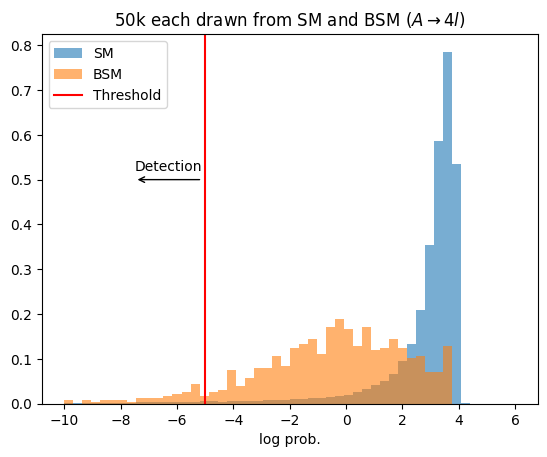

In [251]:
plt.hist(torch.stack(p_vals).flatten().numpy(), range=(-10, 6), bins=50, label='SM', density=True, alpha=0.6)
plt.hist(torch.stack(signal_p_vals).flatten().numpy(), range=(-10, 6), bins=50, label='BSM', density=True, alpha=0.6)
plt.title("50k each drawn from SM and BSM ($A \\rightarrow 4l$)")
plt.axvline(-5, label='Threshold', color='red')
plt.annotate("", xy=(-5.1, 0.5), xytext=(-7.5, 0.5),
             arrowprops=dict(arrowstyle="<-"))
plt.text(-7.5, 0.52, "Detection")
plt.xlabel("log prob.")
plt.legend()

In [225]:
sm_p_vals = torch.stack(p_vals).flatten().numpy()
bsm_p_vals = torch.stack(signal_p_vals).flatten().numpy()

Text(0.5, 0, 'Log prob')

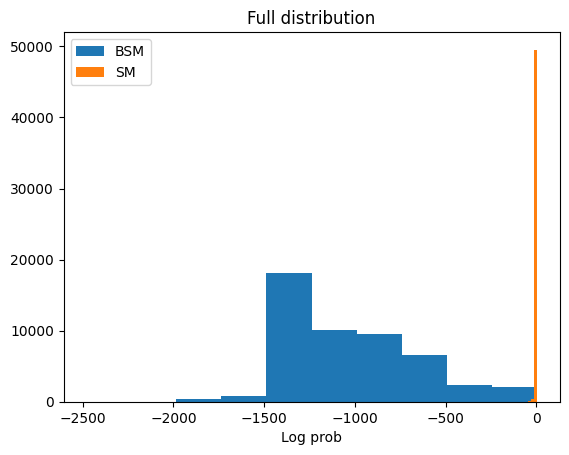

In [254]:
plt.hist(bsm_p_vals, label="BSM")  # more values to the left
plt.hist(sm_p_vals, label="SM")
plt.legend()
plt.title("Full distribution")
plt.xlabel("Log prob")

In [227]:
thresholds = np.linspace(-500, 10, 100)

effs = []
false_alarms = []

for threshold in thresholds:
    eff = np.sum(bsm_p_vals < threshold)
    false_alarm = np.sum(sm_p_vals < threshold)
    effs.append(eff)
    false_alarms.append(false_alarm)

In [228]:
effs = np.array(effs)/50000
false_alarms = np.array(false_alarms)/50000

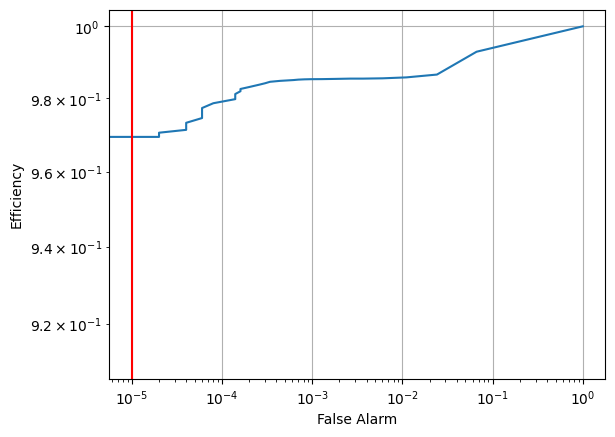

In [229]:
plt.loglog(false_alarms, effs)
plt.ylabel("Efficiency")
plt.xlabel("False Alarm")
plt.axvline(x=1e-5, c='r')
plt.grid()